In [4]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Constants 
PCTO_MIN = -1
PCTO_MAX = 1
PCTO_STEP = 0.5
OTC_MIN = -1.5
OTC_MAX = 1.5
OTC_STEP = 0.25
# Download SPX data from Yahoo Finance
spx_data = yf.download('^GDAXI', start='2007-01-01', end='2022-12-31')

# Calculate previous close-to-open and open-to-close percentage changes
spx_data['Previous_Close_to_Open'] = np.clip((spx_data['Open'] - spx_data['Close'].shift(1)) / spx_data['Close'].shift(1) * 100, PCTO_MIN, PCTO_MAX)
spx_data['Open_to_Close'] = np.clip((spx_data['Close'] - spx_data['Open']) / spx_data['Open'] * 100, OTC_MIN, OTC_MAX)

# Define bins for previous close-to-open percentage change and open-to-close percentage change
prev_close_to_open_bins = np.arange(PCTO_MIN, PCTO_MAX + PCTO_STEP, PCTO_STEP)
open_to_close_bins = np.arange(OTC_MIN, OTC_MAX + OTC_STEP, OTC_STEP)



[*********************100%%**********************]  1 of 1 completed


In [3]:
kor_tab = spx_data[['Previous_Close_to_Open', 'Open_to_Close']]

In [4]:
print(kor_tab.corr())

                        Previous_Close_to_Open  Open_to_Close
Previous_Close_to_Open                1.000000       0.048176
Open_to_Close                         0.048176       1.000000


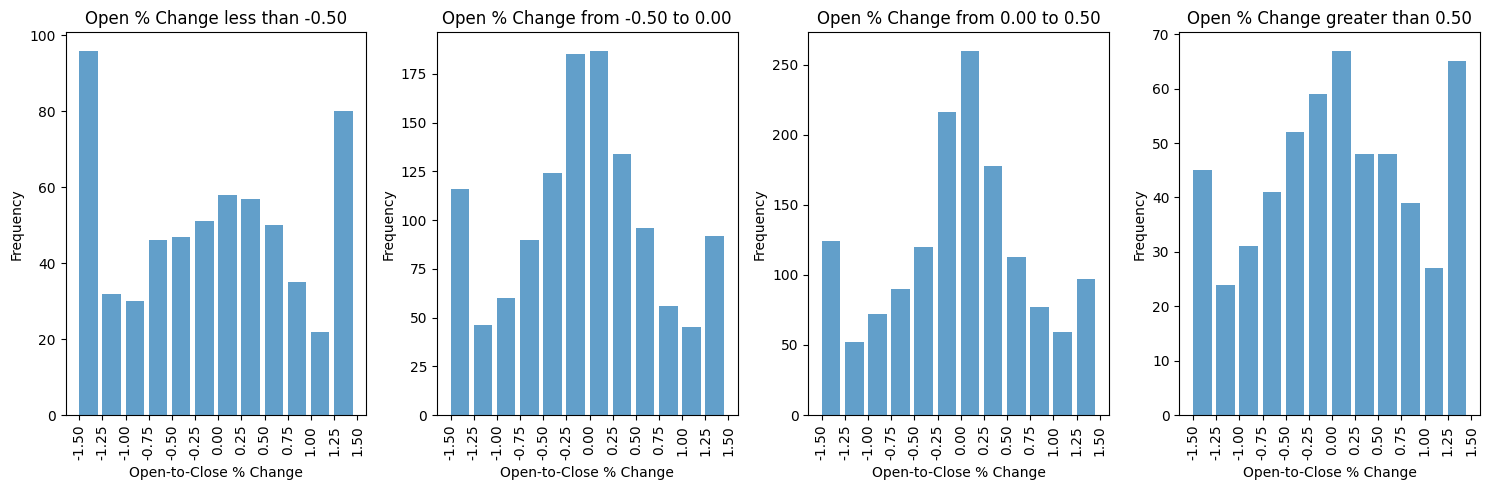

In [5]:
# Create subplots for histograms
fig, axs = plt.subplots(1, len(prev_close_to_open_bins) - 1, figsize=(15, 5))

# Loop through previous close-to-open percentage change bins
for i in range(len(prev_close_to_open_bins) - 1):
    prev_open_mask = (spx_data['Previous_Close_to_Open'] >= prev_close_to_open_bins[i]) & (spx_data['Previous_Close_to_Open'] < prev_close_to_open_bins[i + 1])
    subset = spx_data[prev_open_mask]

    # Calculate histogram for the current previous close-to-open bin
    hist, bin_edges = np.histogram(subset['Open_to_Close'], bins=open_to_close_bins)

    # Plot histogram for the current bin
    axs[i].bar(bin_edges[:-1], hist, width=0.2, align='edge', alpha=0.7)
    if i == 0:
        axs[i].set_title(f"Open % Change less than {prev_close_to_open_bins[i+1]:.2f}")
    elif i == len(prev_close_to_open_bins) - 2:
        axs[i].set_title(f"Open % Change greater than {prev_close_to_open_bins[i]:.2f}")
    elif i > 0:
        axs[i].set_title(f"Open % Change from {prev_close_to_open_bins[i]:.2f} to {prev_close_to_open_bins[i+1]:.2f}")
    axs[i].set_xlabel('Open-to-Close % Change')
    axs[i].set_ylabel('Frequency')
    
    # Add X-axis labels
    axs[i].set_xticks(open_to_close_bins)
    axs[i].set_xticklabels([f'{x:.2f}' for x in open_to_close_bins], rotation=90)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

In [1]:
def generate_open_close_signals(spx_data):
    PCTO_MIN = -1
    PCTO_MAX = 1
    PCTO_STEP = 0.5
    OTC_MIN = -1.5
    OTC_MAX = 1.5
    OTC_STEP = 0.25
    
    spx_data['Previous_Close_to_Open'] = np.clip((spx_data['Open'] - spx_data['Close'].shift(1)) / spx_data['Close'].shift(1) * 100, PCTO_MIN, PCTO_MAX)
    spx_data['Open_to_Close'] = np.clip((spx_data['Close'] - spx_data['Open']) / spx_data['Open'] * 100, OTC_MIN, OTC_MAX)
    
    signals = [None]*len(spx_data['Previous_Close_to_Open'])
    for i in range(1, len(spx_data['Previous_Close_to_Open'])):
        if spx_data['Previous_Close_to_Open'].iloc[i] >= 0.5 and spx_data['Open'][i] < spx_data['ema200'][i]:
            signals[i] = 'Buy'

    for i in range(1, len(spx_data['Previous_Close_to_Open'])):
        if spx_data['Previous_Close_to_Open'].iloc[i] <= -0.5 and spx_data['Open'][i] > spx_data['ema200'][i]:
            signals[i] = 'Sell'
    return signals

In [5]:
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
#tickers:
#tesla TSLA
#spx500 ^GSPC , nasdaq100 ^ndx, dax ^GDAXI
#EURUSD=X
#amazon amzn ,
start_date = '2021-01-06'
end_date = '2023-12-21'
symbol = '^GDAXI '
spx_data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
initial_money = 10000
capital = 10000
spx_data['equity'] = [None]*len(spx_data['Close'])
spx_data["ema200"] = spx_data['Close'].ewm(span=80, adjust=False, min_periods=12).mean()

#Determine the Buy signals 
spx_data['Signal'] = generate_open_close_signals(spx_data)
spread = 0.0004
num_shares=0
final_balance=0
# Simulate buying and selling based on the generated signals
num_trades=0
leverage =2

for i in range(len(spx_data)):
    if spx_data['Signal'][i] == 'Buy':
        num_shares= initial_money/spx_data['Open'][i]*leverage
        initial_money = initial_money - (num_shares*spx_data['Open'][i])
        initial_money = initial_money - (spread*num_shares*spx_data['Open'][i])
        num_trades=num_trades+1
        initial_money= initial_money+ (num_shares*spx_data['Close'][i])
    
    if spx_data['Signal'][i] == 'Sell':
            num_shares= initial_money/spx_data['Open'][i]*leverage
            initial_money = initial_money + (num_shares*spx_data['Open'][i])
            initial_money = initial_money - (spread*num_shares*spx_data['Open'][i])
            num_trades=num_trades+1
            initial_money= initial_money- (num_shares*spx_data['Close'][i])
   
    spx_data['equity'][i]= initial_money

# Calculate the final balance based on the last stock price and remaining number of shares
totalreturn = (initial_money-capital)/capital*100
# Print the final balance and profit/loss
print(f"final_balance: {   initial_money:.2f} $")
print(f"Profit/Loss:  {initial_money - capital:.2f} $")
print(f"Total return: {totalreturn:.2f} %")
print(f"Total trades: {num_trades:} ")

[*********************100%%**********************]  1 of 1 completed
final_balance: 12156.53 $
Profit/Loss:  2156.53 $
Total return: 21.57 %
Total trades: 113 


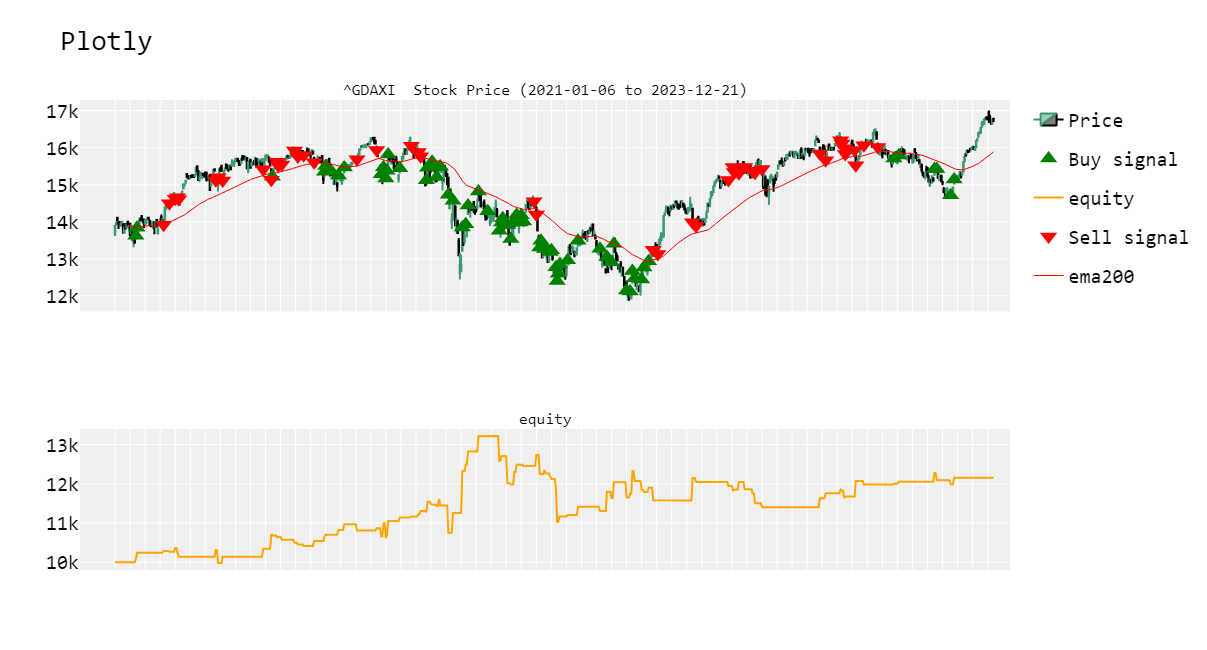

In [8]:
%run "C:\\Users\\adamj\\Documents\\Projekty_Python\\Quant_trading\\Plotting_backtesting.ipynb"
ploting_results_vectorbt_openclose(spx_data)